In [23]:
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import AppLayout, Button, GridspecLayout
from ipywidgets import interact, interact_manual
import nbimporter
from Project.Utils.visualize import  search
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import plotly.express as px
import os
from math import nan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display_html
from Project.Utils.visualize import *
import Notebook_Time_Series as Nbook_Times


In [24]:
col_country = 'Country'
col_year = 'Year'
col_region = 'Region'


data_path = os.getcwd() + '/Databases/'
output_path = os.getcwd() + '/Output/'
country_path = output_path + '/Country/'
region_path = output_path + '/Region/'
cluster_path = output_path + '/Cluster/'


file_regions = '/AuxiliarData/world-regions-mod.csv'
file_gold = 'GoldDataframe.csv'
file_corr_pearson = 'Corr_DF_Pearson.csv'
file_corr_spearman = 'Corr_DF_Spearman.csv'
file_shifted_corr_country = 'Shifted_Corr_Country.csv'
file_shifted_corr_region = 'Shifted_Corr_Region.csv'


df_regions = pd.read_csv(data_path + file_regions, index_col = [col_region, col_country])
df_gold  = pd.read_csv(output_path + file_gold, index_col = [col_country, col_year, col_region])
df_corr_pearson = pd.read_csv(output_path + file_corr_pearson)
df_corr_spearman = pd.read_csv(output_path + file_corr_spearman, index_col = col_country)
df_shifted_corr_country = pd.read_csv(output_path + file_shifted_corr_country)
df_shifted_corr_region  = pd.read_csv(output_path + file_shifted_corr_region)


global PVALUE_VAR 
PVALUE_VAR = 0.05

#Save list of countries, regions and indicators
country_list = list(np.sort(df_gold.index.get_level_values('Country').unique()))
region_list = list(np.sort(df_gold.index.get_level_values('Region').unique()))
indicators = list(df_gold.columns)
indicators.remove('GDP')

#Search for the min , max year in the df_gold
min_year = min(df_gold.index.get_level_values('Year').unique())
max_year = max(df_gold.index.get_level_values('Year').unique())

#Used for median region and global widget
median_corr_df_pearson_region = pd.merge(df_corr_spearman, df_regions, how = 'inner', left_index = True, right_index = True).groupby(level = col_region).median()
median_corr_df_spearman_region = pd.merge(df_corr_spearman, df_regions, how = 'inner', left_index = True, right_index = True).groupby(level = col_region).median()
median_corr_df_pearson = pd.merge(df_corr_spearman, df_regions, how = 'inner', left_index = True, right_index = True).median().rename('GDP Pearson Corr')
median_corr_df_spearman = pd.merge(df_corr_spearman, df_regions, how = 'inner', left_index = True, right_index = True).median().rename('GDP Spearman Corr')

# Precompute contries by region normalized
countries_by_region = {}
for r in region_list:
    countries_by_region[r] = Nbook_Times.load_by_region(r, df_gold)

In [36]:
country = 'Spain'
region = 'South Asia'
zone = 'Spain'
by = 'Country'
indicator  = 'Homicides'
threshold = 0.7
years = (2000, 2010)



In [37]:
df_zone = get_zone(df_gold, countries_by_region, country, by)

In [43]:
def globalGrapgh(df_corr_spearman, indicator):
    N = 10
    fig = px.choropleth(df_corr_spearman, locations = df_corr_spearman.index, locationmode='country names', 
                        color = indicator, projection="natural earth",
                        color_continuous_scale='RdBu',
                        width = 700, height=500)

    pos_corr = df_corr_spearman.drop(df_corr_spearman.columns.difference([indicator]), axis = 1).sort_values(by = indicator, axis = 0, ascending = False).head(n = N)
    neg_corr = df_corr_spearman.drop(df_corr_spearman.columns.difference([indicator]), axis = 1).sort_values(by = indicator, axis = 0, ascending = True).head(n = N)

    pos_corr = pos_corr.loc[pos_corr[indicator] > 0]
    neg_corr = neg_corr.loc[neg_corr[indicator] < 0]


    fig.update(layout_coloraxis_showscale=True)
    fig.show()
    
    pos_styler = pos_corr.style.set_table_attributes("style='display:inline'").set_caption('Direct correlation')
    neg_styler = neg_corr.style.set_table_attributes("style='display:inline'").set_caption('Inverse correlation')

    space = "\xa0" * 10
    display_html(pos_styler._repr_html_() + space  + neg_styler._repr_html_(), raw=True)

globalGrapgh(df_corr_spearman, indicator)

,Homicides
Country,
Uruguay,0.764630
Burkina Faso,0.764522
Costa Rica,0.760729
Belize,0.738115
Myanmar,0.687596
Mexico,0.642393
Greece,0.563903
Trinidad and Tobago,0.539280
,Homicides


In [41]:
def tableOut(threshold, country):
    df = search(threshold, col_country, country)
    if df.empty:
        return print("No indicators have been found.")
          
    left1 = pd.Series([PVALUE_VAR, PVALUE_VAR], index=['P-value Pearson', 'P-value Spearman'])
    left2 = pd.Series([-1, -1], index=['GDP Pearson Corr', 'GDP Spearman Corr'])
    left3 = pd.Series([0, 0], index=['GDP Pearson Corr', 'GDP Spearman Corr'])
    df = df.style.highlight_between(left = left1, right = 1.5, axis = 1, props='color:white; background-color:red;')\
                 .highlight_between(left = left2, right = 1.5, axis = 1, props='color:white; background-color:#929bfc;')\
                 .highlight_between(left = left3, right = 1.5, axis = 1, props='color:white; background-color:#b3b9ff;')\
                 .format('{:,.4f}', subset = ['GDP Pearson Corr', 'GDP Spearman Corr'])\
                 .format('{:,.12f}', subset = ['P-value Pearson', 'P-value Spearman']) 
    
    
    display(df)

tableOut(threshold, country)

,GDP Pearson Corr,P-value Pearson,GDP Spearman Corr,P-value Spearman
Indicator,,,,
R&D expenditure %GDP,0.9218,0.000000002932,0.8334,0.000002719194
Researchers in R&D,0.8883,0.000000076315,0.7672,0.000049374718
% Female Employment,0.8869,0.000000085176,0.7243,0.000204871523
Tertiary School Gender Parity,0.7199,0.000233451377,0.7147,0.000271748672
AgriShareGDP,-0.9246,0.000000002107,-0.8529,0.000000903819
Employment in agriculture,-0.9320,0.000000000813,-0.7293,0.000176140449


In [25]:
def tableRegMed(region, threshold):    
    median_corr_series_pearson_region = median_corr_df_pearson_region.loc[region]
    median_corr_series_pearson_region.name = 'GDP Pearson Corr'
    median_corr_series_spearman_region = median_corr_df_spearman_region.loc[region]
    median_corr_series_spearman_region.name = 'GDP Spearman Corr'
    df = pd.concat([median_corr_series_pearson_region, median_corr_series_spearman_region], axis = 1)
    df = df.loc[(abs(df['GDP Pearson Corr']) >= threshold) & (abs(df['GDP Spearman Corr']) >= threshold)]

    if df.empty:
        return print("No indicators have been found.")

    df = df.sort_values(by = df.columns[0], ascending = False, key = lambda row: df.sum(axis = 1))

    left1 = pd.Series([-1, -1], index = ['GDP Pearson Corr', 'GDP Spearman Corr'])
    left2 = pd.Series([0, 0], index = ['GDP Pearson Corr', 'GDP Spearman Corr'])
    df = df.style\
        .highlight_between(left = left1, right = 1.5, axis = 1, props = 'color:white; background-color:#929bfc;')\
        .highlight_between(left = left2, right = 1.5, axis = 1, props = 'color:white; background-color:#b3b9ff;')\
        .format('{:,.4f}', subset = ['GDP Pearson Corr', 'GDP Spearman Corr'])\
    
    display(df)

tableRegMed(region, threshold)

,GDP Pearson Corr,GDP Spearman Corr
Life Expectancy,0.9877,0.9877
Population,0.9805,0.9805
Employment in services,0.9756,0.9756
Employment in industry,0.9386,0.9386
Tertiary School Gender Parity,0.9214,0.9214
% Female Employment,0.7325,0.7325
AgriShareGDP,-0.7386,-0.7386
Homicides,-0.7856,-0.7856
% Vulnerable male employment,-0.9217,-0.9217
% Population Growth,-0.9416,-0.9416


In [26]:
def tableWorldMed(threshold):
    df = pd.concat([median_corr_df_pearson, median_corr_df_spearman], axis = 1)
    df = df.loc[(abs(df['GDP Pearson Corr']) >= threshold) & (abs(df['GDP Spearman Corr']) >= threshold)]

    if df.empty:
        return print("No indicators have been found.")

    df = df.sort_values(by = df.columns[0], ascending = False, key = lambda row: df.sum(axis = 1))

    left1 = pd.Series([-1, -1], index = ['GDP Pearson Corr', 'GDP Spearman Corr'])
    left2 = pd.Series([0, 0], index = ['GDP Pearson Corr', 'GDP Spearman Corr'])
    df = df.style.highlight_between(left = left1, right = 1.5, axis = 1, props = 'color:white; background-color:#929bfc;')\
                 .highlight_between(left = left2, right = 1.5, axis = 1, props = 'color:white; background-color:#b3b9ff;')\
                 .format('{:,.4f}', subset = ['GDP Pearson Corr', 'GDP Spearman Corr'])\

    display(df)

tableWorldMed(threshold)

,GDP Pearson Corr,GDP Spearman Corr
Population,0.9167,0.9167
Life Expectancy,0.9144,0.9144
Employment in services,0.8672,0.8672
Researchers in R&D,0.7870,0.7870
Tertiary School Gender Parity,0.7147,0.7147
AgriShareGDP,-0.7145,-0.7145
Death Rate,-0.7610,-0.7610
% Soldiers,-0.7815,-0.7815
% Vulnerable female employment,-0.8030,-0.8030
% Vulnerable male employment,-0.8087,-0.8087


In [27]:
class WidgetTimeWindowCountryStatus:
    def __init__(self):
        self.filter_by = "Country"
        self.zone = None
        self.data = None
        
status_widget = WidgetTimeWindowCountryStatus()

In [29]:
def time_window_zone(threshold , years):
    
    #Load the selected year range and the global range.
    df_time = searchTimeSeries(threshold, years[0], years[1], True, df_zone)
    df_global = searchTimeSeries(threshold, years[0], years[1], False, df_zone)

    # Display Data
    if years[0] > years[1]: return print("Please, select a valid range of years.")
 
    space = "\xa0" * 10
    try:
        df_time = Nbook_Times.styler_method(df_time, str(years[0]) + '-' + str(years[1]), PVALUE_VAR)._repr_html_()
    except Exception as e: 
        df_time = 'No indicators available for the selected parameters'
    
    try:
        df_global = Nbook_Times.styler_method(df_global, '2000-2020', PVALUE_VAR)._repr_html_()
    except: 
        df_global = 'No indicators available for the selected parameters'

    display_html(df_time + space  + df_global, raw=True)
    

time_window_zone(threshold , years)


,GDP Spearman Corr,P-value Spearman
Indicator,,
% Healthcare Investment,0.9636,0.000001852040
R&D expenditure %GDP,0.9545,0.000004988899
Tertiary School Gender Parity,0.9545,0.000004988899
% Female Employment,0.9450,0.000011606539
Researchers in R&D,0.9450,0.000011606539
Population,0.9364,0.000022082076
Life Expectancy,0.9364,0.000022082076
Employment in services,0.9273,0.000039737743
Civil Liberties,0.8660,0.000566964311


In [39]:
def table_high_country(by, zone):
    if by == 'Country':
        min_diff = 5
        
    elif by == 'Region':
        min_diff = 2
    
    df_highest = Nbook_Times.init_highest_table(indicators)

    i = 0
    computing_text = "Loading "
    print(computing_text, end="\r")
    
    #For all the combination of years...
    for years in Nbook_Times.generate_years_combinations(min_diff, min_year, max_year):
        
        i = (i + 1) % 50
        print (computing_text + "".join(["." for _ in range(i)]), end="\r")
        
        df_aux = searchTimeSeries(0, years[0], years[1], True, df_zone)
        #Delete indicators which are not available that year
        indicators_inter = list(set(indicators) & set(list(df_aux.index)))

        #For all the indicators availble that year....
        for indicator in indicators_inter:
            #Algorithm to search for the highest value
            indicator_corr_pos_last = df_highest[df_highest.index.get_level_values(0) == indicator]["Highest positive Spearman corr"][0]
            indicator_corr_neg_last = df_highest[df_highest.index.get_level_values(0) == indicator]["Highest negative Spearman corr"][0]
            
          
            indicator_corr_aux = df_aux[df_aux.index.get_level_values(0) == indicator]["GDP Spearman Corr"][0]
            indicator_p_value_aux = df_aux[df_aux.index.get_level_values(0) == indicator]["P-value Spearman"][0]

            if indicator_corr_aux != nan and indicator_p_value_aux < PVALUE_VAR:
                if indicator_corr_pos_last < indicator_corr_aux and indicator_corr_aux > 0:
                    df_highest.at[indicator, "Year range"] = str(years[0]) + '-' + str(years[1])
                    df_highest.at[indicator, "Highest positive Spearman corr"] = indicator_corr_aux
                elif indicator_corr_neg_last > indicator_corr_aux and indicator_corr_aux < 0:
                    df_highest.at[indicator, "Year range "] = str(years[0]) + '-' + str(years[1])
                    df_highest.at[indicator, "Highest negative Spearman corr"] = indicator_corr_aux

    df_highest = df_highest.replace(0, nan).dropna(axis=0, how='all').fillna("-")
    
    print("                                                                                    ", end="\r")
    display(df_highest)


table_high_country(by, zone)


,Year range,Highest positive Spearman corr,Year range,Highest negative Spearman corr
Indicator,,,,
AgriShareGDP,-,-,2001-2006,-1.0
CreditToAgriFishForest,2001-2006,0.885714,2000-2016,-0.632353
EmploymentRural,2000-2005,1.0,-,-
% Soldiers,2008-2013,0.942857,2002-2007,-1.0
Employment in industry,2008-2013,0.885714,2001-2006,-1.0
Employment in services,2001-2006,1.0,2008-2013,-0.885714
Birth Rate,2000-2008,0.995825,-,-
Cost business start-up,2008-2017,0.741645,2004-2009,-1.0
Death Rate,-,-,2011-2016,-0.898645


SpearmanrResult(correlation=-0.4941486622797844, pvalue=0.022791477855466827)


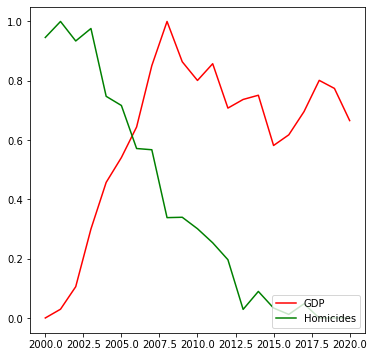

In [42]:

def plot_corr_ind(indicator: str, drop_plot_value: str , years: tuple, df_zone): 
    df_zone = get_years(df_zone, years)
    spear = stats.spearmanr(df_zone[indicator], df_zone['GDP'])
    df_zone = normalize_by_country(df_zone)

    #In case if by is region it groups by year.
    df_zone = df_zone.loc[:,['GDP', indicator]].groupby(level = 'Year').median()

    print(spear)
    plt.figure(figsize=(6,6))
    plt.plot(df_zone.index.get_level_values("Year"), df_zone["GDP"], color="red", label = 'GDP')
    plt.plot(df_zone.index.get_level_values("Year"), df_zone[indicator], color="green", label = indicator)
    plt.legend(loc="lower right")

plot_corr_ind(indicator, country, years, df_zone)